In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller
* check on the limits of time between adjacent clusters, esp. when they have the same mean and/or median
    * if at $x_a$ for $t_1$ then again at $x_a$ for $t_2$, duration between going from and back to $x_a$ should reflect some mimimal amount of time ($2\times$ travel and a stay), 
        * e.g. 
            * from $x_a$ to an unknown $x_b$ with a stay at $x_b$ of the miminum duration and then back to $x_a$ 
            * should satisfy some criterion or _there is no inbetween travel and $t_1$ and $t_2$ are part of the same cluster_
* check of the metrics for inter-subcluster gaps
    * these are also clusters but unlabeled after the first round of clustering

## Notes: 

* **Gaps** 
    * since there are subclusters for a given cluster which are separated by gaps, these gaps ...

### 1-stay
* gap-merging works well when good density; poorly when otherwise

## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.



In [6]:
import numpy as np
import pandas as pd

In [7]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [8]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [10]:
shuffle(colors)

# Sythetic data

In [10]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

In [11]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask

# Clustering

## Split the clusters which have a temporal gap

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

### From here

At this point, it seems that the basic clusters are formed. 

Next, use the IQRs of these clusters as the new bounds for extending the cluster: essentially using the extensible box method.

Note that the IQR can be larger than the allow distance threshold; the box would therefore need to be the smaller of the two but with the same mean and/or median

### Summary

1. `get_clusters_x` finds the clusters based on nearness of events in space and time
2. `merge_clusters` merges neraby clusters based on ...
3. `merge_clusters_2`  merges neraby clusters based on ...
4. `extend_clusters` extend the clusters
5. `separate_clusters` break the overlapping clusters and then re-merge
6. `merge_clusters_2` merge the separated clusters
7. `intersect` the forward and backward clusters

In [21]:
from helper__3stays_v3_scripts import switch_indices

In [22]:
from helper__3stays_v3_scripts__plotting import plot_cluster_boxplots

In [14]:
from helper__3stays_v3_scripts__eval import get_segments_scores

In [ ]:
from helper__metric_box__explore import eval_synth_data

from helper__gaps import merge_clusters

from helper__metric_box__explore import get_cluster_boxplot, kwargs_filled, kwargs_unfilled

from helper__gaps import get_intercluster_metrics

from helper__gaps import merge_cluster_pair, gap_criterion_2, merge_clusters_2, gap_criterion_3

from helper__metric_box__explore import iqr_metrics, get_iqr, get_iqr_mask

In [ ]:
from helper__3stays_v3_scripts import extend_cluster, intersecting_bounds, extend_final_clusters

from helper__3stays_v3_scripts import _extend_edge, get_iqr_mask_x, get_bounded_events, get_extended_clusters

from stay_classification.box_classifier.box_method import get_time_ind
#get_mask, make_box, get_directional_indices, get_thresh_mean, check_means, 

from helper__metric_box__explore import extend_cluster, extend_clusters, extend_edge

In [ ]:
from helper__3stays_v3_scripts import inter_bounds, contains, conta_bounds

In [ ]:
from helper__gaps import merge_clusters_combo

In [23]:
print_clusts = lambda cluster_list : [print(f"[{c[0]:4d},{c[-1]:4d}]") for c in cluster_list]
print_ctimes = lambda cluster_list : [print(f"[{time_arr[c[0]]:6.3f},{time_arr[c[-1]]:6.3f}]") for c in cluster_list]
print_ctdiff = lambda cluster_list : [print(f"{time_arr[c[-1]] - time_arr[c[0]]:6.3f}") for c in cluster_list]
print_times = lambda l: list(map(lambda x: f"{x:6.3f}",l))

In [ ]:
def get_sorted_keys(clusts):
    d = {}
    for n, c in enumerate(clusts):
        d[n] = len(c)

    return [k for k, v in sorted(d.items(), key=lambda item: item[1])]


def check_intersecting_clusters_inds(clusters):
    m = 0
    while (m < len(clusters)):
        # Biggest cluster
        c1 = clusters[m]
        n = m+1
        while (n < len(clusters)):

            if n == m:
                n+=1
                continue

            c2 = clusters[n]
            if inter_bounds(c1,c2):
                return True, m,n
            else:
                n+=1
        m+=1
    return False, 999, 999

def check_intersecting_clusters(clusters):
    
    result, _ , _ = check_intersecting_clusters_inds(clusters)
 
    return result

In [ ]:
def separate_clusters_hier(clusters, verbose=False):
    """
    
    Test:
    clusts = [list(range(2,4)), list(range(8)), list(range(4,8)), list(range(6,10))]
    separate_clusters_hier(clusts)
    [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
    """    
    # Check if any clusters intersect
    new_clusts = clusters.copy()
    
    result, m, n = check_intersecting_clusters_inds(new_clusts)
    
    if result:
        if verbose: print(m, n)
    else:
        return clusters

    while result:
        
        if verbose: print_clusts(new_clusts)
        if verbose: print(len(new_clusts))
        c1 = new_clusts.pop(m)
        if m < n: 
            n-=1
        c2 = new_clusts.pop(n)

        if verbose: print(len(new_clusts))
        if verbose: print(f"{m:4d}: [{c1[0]:4d},{c1[-1]:4d}] and [{c2[0]:4d},{c2[-1]:4d}]")

        '''sc1 = set(c1)
        sc2 = set(c2)

        intersexion = sc1.intersection(sc2)

        sc1_diff = sc1.difference(intersexion)
        sc2_diff = sc2.difference(intersexion)                
        '''
        
        sc1_diff, intersec, sc2_diff = split_list(c1,c2)        
        
        #sc1_diff = list(sc1_diff)
        if len(sc1_diff) > 0:
            new_clusts.append(sc1_diff)
        if verbose: print("len(sc1_diff)",len(sc1_diff))
        
        #intersexion = list(intersexion)
        if len(intersec) > 0:
            new_clusts.append(intersec)
        if verbose: print("len(intersexion)",len(intersec))
        
        #sc2_diff = list(sc2_diff)
        if len(sc2_diff) > 0:
            new_clusts.append(sc2_diff)
        if verbose: print("len(sc2_diff)",len(sc2_diff))
        
        if verbose: print(len(new_clusts))
        if verbose: print_clusts(new_clusts) 
        
        result, m, n = check_intersecting_clusters_inds(new_clusts)
        if verbose: print(result,m,n)
        if verbose: print()
        
    return new_clusts

In [ ]:
from helper__gaps import merge_clusters_combo, gap_criterion

In [ ]:
def split_list( l1, l2): 
    
    """
    Usage:
    split_list(range(10), list(range(4,7)))
    ([0, 1, 2, 3], [4, 5, 6], [7, 8, 9])
    """
    
    if len(l1) < len(l2):
        return ([e for e in l2 if e < min(l1)], l1, [e for e in l2 if e > max(l1)])
    else:
        return ([e for e in l1 if e < min(l2)], l2, [e for e in l1 if e > max(l2)])        

# Start here

In [15]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [13]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays

In [11]:
from synthetic_data.canonical_stays import get3e, get3

In [17]:
from helper__get_clusters import get_clusters_1, get_clusters_2, get_clusters_3, get_clusters_4

In [3]:
time_thresh = 1/6
dist_thresh=0.25

In [12]:
rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_

In [61]:
event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

Event frac. =  0.010
Dupli. frac. =  0.000


In [42]:
x_dist = rand_range(0.52,5.0, 10)[0]
mid_len = rand_range(0.2, 10, 10)[0]
shift = rand_range(-10, 10, 21)[0]

4.735388721211814 1.6949192498436072 1.799862488457558


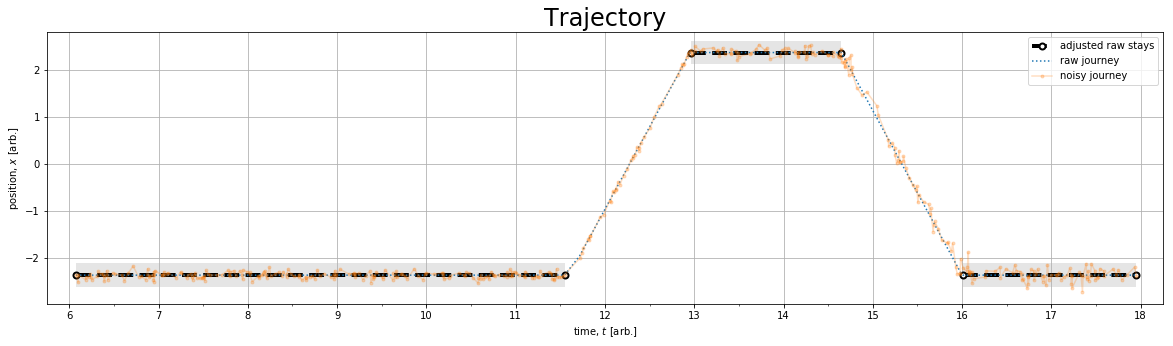

In [62]:
print(x_dist, mid_len, shift)
if np.random.randint(0,2,1):
    stays = get3e(x_dist, mid_len, shift)
else:
    stays = get3e(x_dist, mid_len, shift)    

continuation = True
while continuation:
    try:
        time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
        continuation = False
    except:
        pass
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_xlim([5.75,18.25]);

In [74]:
verbose = True
print(time_arr.size)

if verbose: print("version 1")
clusters_1 = get_clusters_1(time_arr, noise_arr, dist_thresh, time_thresh)
print_clusts(clusters_3);
print()

if verbose: print("version 2")
clusters_2 = get_clusters_2(time_arr, noise_arr, dist_thresh, time_thresh)
print_clusts(clusters_3);
print()

if verbose: print("version 3")
clusters_3 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh)
print_clusts(clusters_3);
print()

if verbose: print("version 4")
clusters_4 = get_clusters_4(time_arr, noise_arr, dist_thresh, time_thresh)
print_clusts(clusters_4);
print()

437
version 1
0 209 cont
239 241 cont
[   0, 208]
[ 213, 215]
[ 221, 225]
[ 229, 236]
[ 243, 311]
[ 313, 317]
[ 325, 335]
[ 341, 343]
[ 347, 349]
[ 351, 352]
[ 357, 436]

version 2
[   0, 208]
[ 213, 215]
[ 221, 225]
[ 229, 236]
[ 243, 311]
[ 313, 317]
[ 325, 335]
[ 341, 343]
[ 347, 349]
[ 351, 352]
[ 357, 436]

version 3
Checking last cluster:   20,  412,  413,  437
0.11 416 435 20
0.11 416 436 21
2: 22
[   0, 208]
[ 213, 215]
[ 221, 225]
[ 229, 236]
[ 243, 311]
[ 313, 317]
[ 325, 335]
[ 341, 343]
[ 347, 349]
[ 351, 352]
[ 357, 436]

version 4
[415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435]
[ 210, 215]
[ 218, 227]
[ 228, 236]
[ 242, 317]
[ 319, 320]
[ 324, 337]
[ 338, 345]
[ 346, 349]
[ 350, 354]
[ 356, 435]



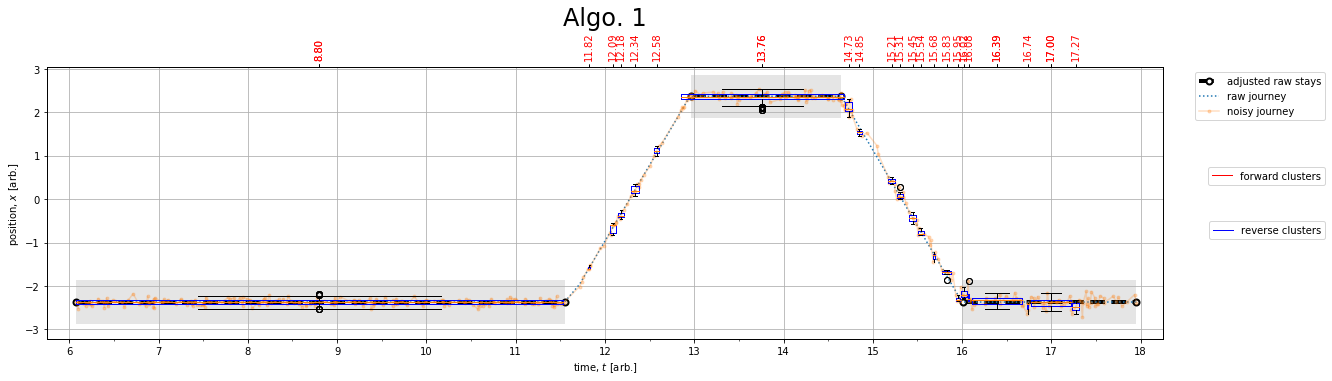

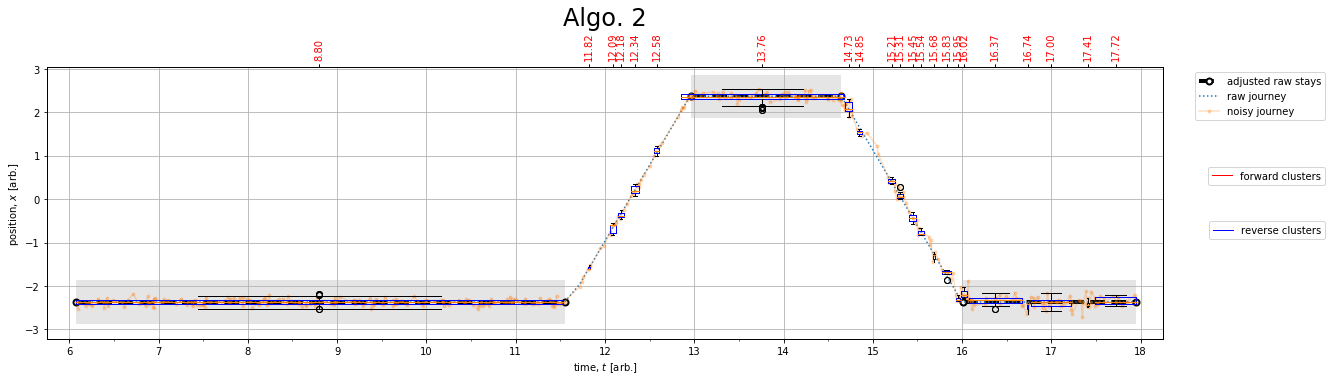

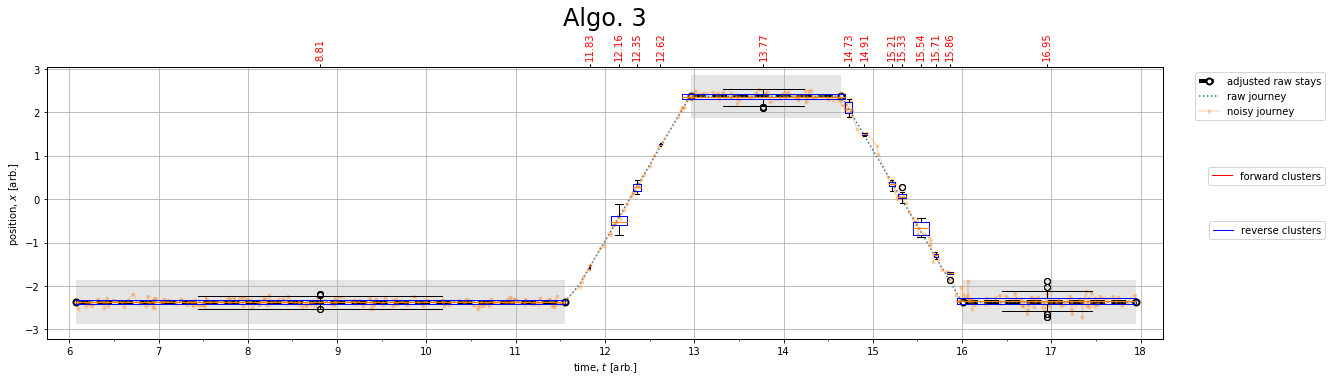

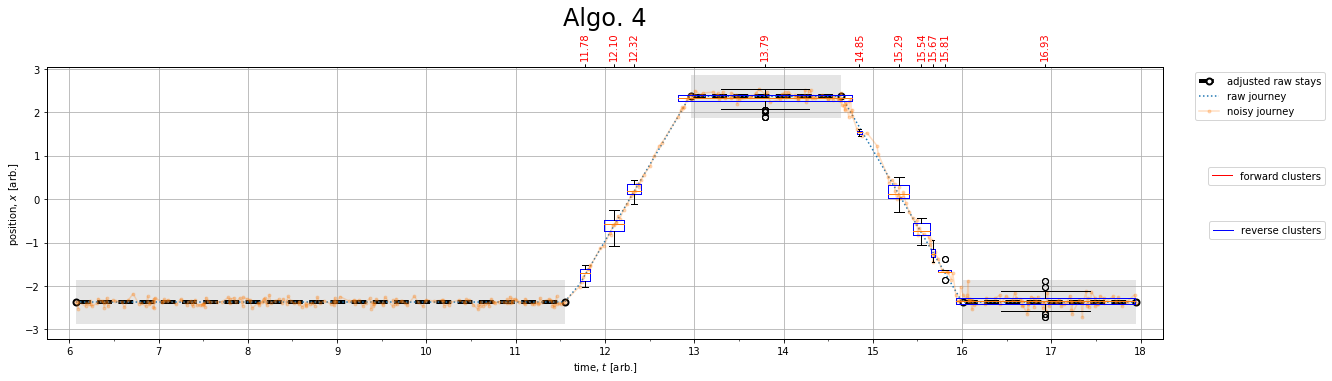

In [114]:
ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]


ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_1, switch_indices(clusters_1, time_arr.shape[0]), configs)
ax.set_ylim(ylim);
ax.set_title("Algo. 1", fontsize=24)

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_2, switch_indices(clusters_2, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Algo. 2", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_3, switch_indices(clusters_3, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Algo. 3", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_4, switch_indices(clusters_4, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Algo. 4", fontsize=24);

In [ ]:
get_segments_scores(time_arr, segments, ext_clusters_2m, True);


### Notes
#### 3 clusters
* overlapping clusters
    * embedded and also identitcal clusters
    * **Notes**
        * usually have the same median and mean ("M&M"), but not always
    * overlap on edge between two spatially close clusters
        * maybe not sharing M&M,
    * megacluster when two clusters share an $x$ (rare)
        * should be avoidable with gap durations
* missing short clusters
    * these usually occur on the edges
    * if using a IQR-postfilter, many of these will get dropped
    
#### 4 clusters
* mis-identified cluster, aka "floater"
    * part of a travel
        * in the canonical 3-stays, these are always between larger stays
        * **Todo** 
            * _check if these have insufficient events with the IQR-mask_
            * _check if these have insufficient duration with the IQR-mask_            
    * seems to be short in duration
* overlapping clusters
    * embedded and also identitcal clusters
    * **Notes**
        * usually have the same median and mean ("M&M"), but not always
    * overlap on edge between two spatially close clusters
        * maybe not sharing M&M,
    * megacluster when two clusters share an $x$ (rare)
        * should be avoidable with gap durations
    * missing short clusters and overlaps/duplicates

In [115]:
if verbose: print("version 3")
clusters_3 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh, True)
print(len(clusters_3), "Clusters:")
print_clusts(clusters_3);
print()

version 3
	Appended: [   0,  209]
	Appended: [   0,  212]
	Appended: [ 211,  216]
	Appended: [ 213,  218]
		Merged
	Appended: [ 217,  224]
	Appended: [ 219,  228]
		Merged
	Appended: [ 225,  236]
	Appended: [ 229,  238]
		Merged
	Appended: [ 237,  241]
	Appended: [ 239,  309]
	Appended: [ 243,  318]
	Appended: [ 310,  321]
	Appended: [ 319,  323]
		Merged
	Appended: [ 322,  328]
	Appended: [ 324,  336]
	Appended: [ 329,  340]
	Appended: [ 337,  344]
	Appended: [ 341,  346]
		Merged
	Appended: [ 345,  350]
	Appended: [ 347,  355]
	Appended: [ 351,  359]
	Appended: [ 356,  363]
		Merged
	Appended: [ 364,  384]
		Merged
	Appended: [ 365,  388]
	Appended: [ 385,  410]
		Merged
	Appended: [ 411,  413]
		Merged
	Appended: [ 416,  421]
		Merged
	Appended: [ 417,  423]
		Merged
	Appending: [ 422,  436]
		Merged
17 Clusters:
[   0, 209]
[   0, 212]
[ 211, 218]
[ 217, 228]
[ 225, 238]
[ 237, 241]
[ 239, 309]
[ 243, 318]
[ 310, 323]
[ 322, 328]
[ 324, 336]
[ 329, 340]
[ 337, 346]
[ 345, 350]
[ 34

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
